In [2]:
import pandas as pd

# Load EEG data
df = pd.read_csv('../data/confusion_eeg.csv')

# Show structure
print(df.shape)
df.head()

(12811, 15)


,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [3]:
# Drop rows with missing values
df.dropna(inplace=True)

# Features we'll use
features = [
    'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2'
]

# Target variable
target = 'user-definedlabeln'

X = df[features]
y = df[target]


In [5]:
X.head()

,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0
1,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0
2,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0
3,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0
4,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0


In [6]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: user-definedlabeln, dtype: float64

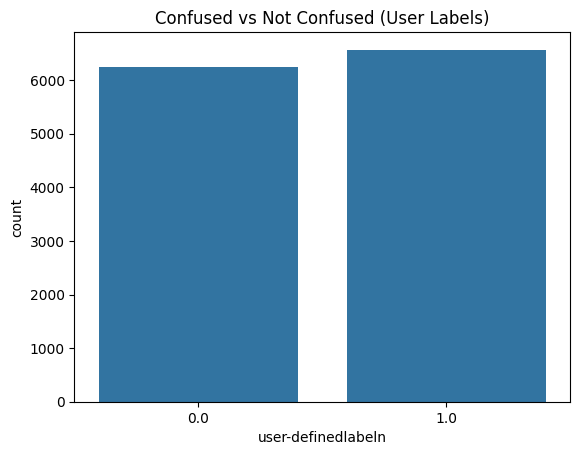

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title("Confused vs Not Confused (User Labels)")
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

clf = SVC(kernel='rbf', class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5817401482637534
              precision    recall  f1-score   support

         0.0       0.55      0.72      0.63      1249
         1.0       0.63      0.45      0.52      1314

    accuracy                           0.58      2563
   macro avg       0.59      0.59      0.58      2563
weighted avg       0.59      0.58      0.57      2563



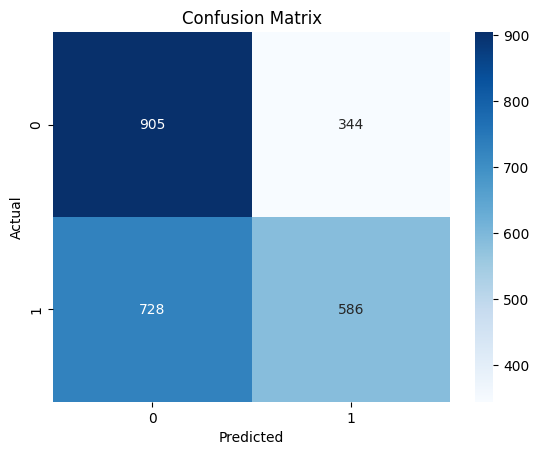

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Accuracy: 0.6090518923136949
              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      1249
         1.0       0.62      0.62      0.62      1314

    accuracy                           0.61      2563
   macro avg       0.61      0.61      0.61      2563
weighted avg       0.61      0.61      0.61      2563



/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


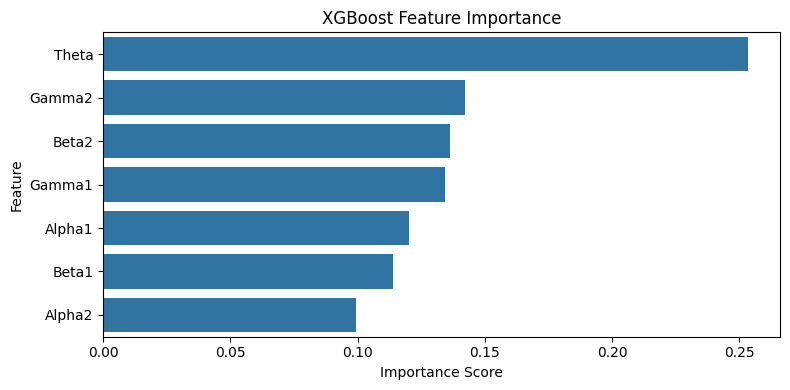

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [13]:
import pickle
with open('../backend/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)
